# Extract, Transform and Load

* We want to join all data sets as possible.
* Consider date index as reference for merge data.

> Elias Castellanos Alamilla

> April-2023

In [1]:
# Dependencies

# Data manipulation
from geopandas import GeoDataFrame
# from sqlalchemy import create_engine, text
from functools import reduce
# import mysql.connector
import geopandas as gpd
import pandas as pd

# Maths
import numpy as np

# Data viz
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime

# OS
import os

In [3]:
# Local functions
# Data manipulation
from data_gathering import *

# set config
from app.config import *

Project path files OK!


In [4]:
cetes = read_sql_data(db_connection, 'cetes')
pesos = read_sql_data(db_connection, 'dls_mx')
inflacion = read_sql_data(db_connection, 'inflacion_anual_mx')
inflacion_subyacente = read_sql_data(db_connection, 'inflacion_subyacente_mx')
iit = read_sql_data(db_connection, 'interes_interbancariomx_28')
mme = read_sql_data(db_connection, 'mme')
udis = read_sql_data(db_connection, 'udis')
historico_produccion = read_sql_data(db_connection, 'produccion_nacional_cnh')
shapefiles_mx = read_sql_data(db_connection, 'mx_wells_coordinates')

In [5]:
cetes.set_index('fecha', inplace=True)
pesos.set_index('fecha', inplace=True)
inflacion.set_index('fecha', inplace=True)
inflacion_subyacente.set_index('fecha', inplace=True)
iit.set_index('fecha', inplace=True)
mme.set_index('fecha', inplace=True)
udis.set_index('fecha', inplace=True)

In [6]:
# No frequency, we need to convert to 'MS'

pd.infer_freq(pesos.index)

In [7]:
len(pesos.groupby(pd.Grouper(freq='MS')).mean())

424

### set monthly start frequency and DateTimeIndex

* cetes
* pesos
* inflacion
* iit
* mme
* udis

In [8]:
# Change frequency

pesos_monthly = pesos.groupby(pd.Grouper(freq='MS')).mean()
pd.infer_freq(pesos_monthly.index)

'MS'

In [9]:
udis_monthly = udis.groupby(pd.Grouper(freq='MS')).mean()
pd.infer_freq(udis_monthly.index)

'MS'

In [10]:
iit_monthly = iit.groupby(pd.Grouper(freq='MS')).mean()
pd.infer_freq(iit_monthly.index)

'MS'

In [11]:
mme_monthly = mme.groupby(pd.Grouper(freq='MS')).mean()
pd.infer_freq(mme_monthly.index)

'MS'

In [12]:
currencies = [pesos_monthly, udis_monthly, mme_monthly]
indicators = [cetes, inflacion, inflacion_subyacente, iit_monthly]

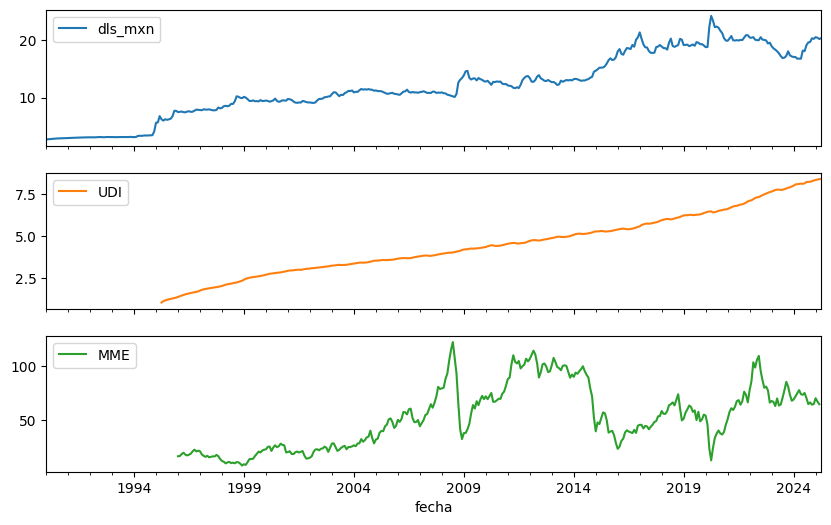

In [13]:
divisas = pd.concat(currencies, join='outer', axis=1)
divisas.plot(subplots=True, layout=(3,1), figsize=(10, 6))

plt.show()

In [14]:
divisas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 424 entries, 1990-01-01 to 2025-04-01
Freq: MS
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dls_mxn  424 non-null    float64
 1   UDI      361 non-null    float64
 2   MME      351 non-null    float64
dtypes: float64(3)
memory usage: 29.4 KB


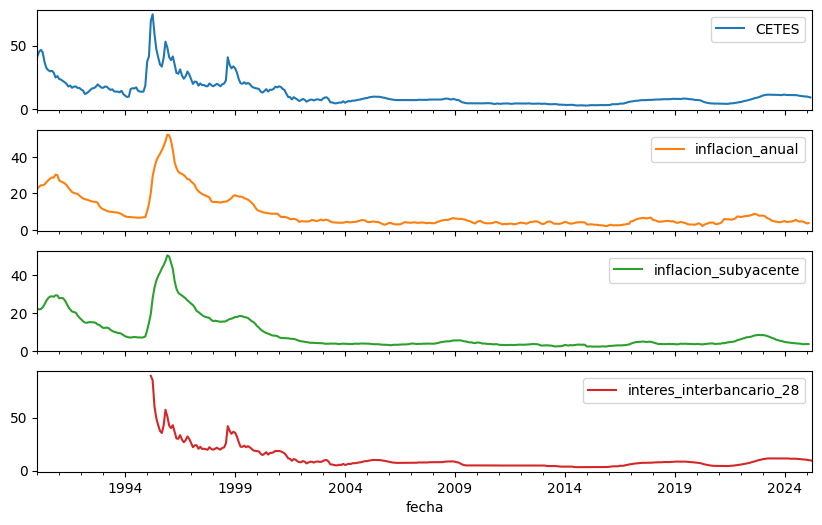

In [15]:
indicadores = reduce(lambda left, right: pd.merge(left, right, on=['fecha'], how='outer'), indicators)
indicadores.plot(subplots=True, layout=(4,1), figsize=(10, 6))

plt.show()

In [16]:
indicadores.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 424 entries, 1990-01-01 to 2025-04-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CETES                     423 non-null    float64
 1   inflacion_anual           422 non-null    float64
 2   inflacion_subyacente      422 non-null    float64
 3   interes_interbancario_28  362 non-null    float64
dtypes: float64(4)
memory usage: 16.6 KB


In [17]:
pd.infer_freq(indicadores.index)

'MS'

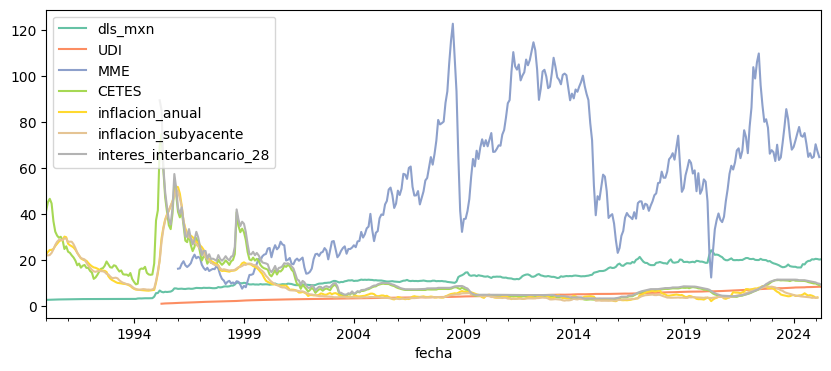

In [18]:
# Join all features into 1 file
df = pd.concat([divisas, indicadores], join='outer', axis=1)
df.plot(figsize=(10, 4), colormap='Set2')

plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 424 entries, 1990-01-01 to 2025-04-01
Freq: MS
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dls_mxn                   424 non-null    float64
 1   UDI                       361 non-null    float64
 2   MME                       351 non-null    float64
 3   CETES                     423 non-null    float64
 4   inflacion_anual           422 non-null    float64
 5   inflacion_subyacente      422 non-null    float64
 6   interes_interbancario_28  362 non-null    float64
dtypes: float64(7)
memory usage: 42.7 KB


In [20]:
df.head()

,dls_mxn,UDI,MME,CETES,inflacion_anual,inflacion_subyacente,interes_interbancario_28
fecha,,,,,,,
1990-01-01,2.701659,NaN,NaN,41.29,22.48,22.23,NaN
1990-02-01,2.731658,NaN,NaN,45.20,23.57,22.02,NaN
1990-03-01,2.760357,NaN,NaN,46.65,24.40,22.21,NaN
1990-04-01,2.791184,NaN,NaN,44.64,24.43,23.11,NaN
1990-05-01,2.821791,NaN,NaN,36.92,24.89,24.66,NaN


In [21]:
df.tail()

,dls_mxn,UDI,MME,CETES,inflacion_anual,inflacion_subyacente,interes_interbancario_28
fecha,,,,,,,
2024-12-01,20.266055,8.331915,64.934091,9.85,4.21,3.65,10.380720
2025-01-01,20.549018,8.362028,70.373913,9.86,3.59,3.66,10.282523
2025-02-01,20.457137,8.385948,67.334500,9.45,3.77,3.65,9.878884
2025-03-01,20.241745,8.410383,64.768000,9.10,NaN,NaN,9.739170
2025-04-01,20.358700,8.422654,NaN,NaN,NaN,NaN,9.270400


In [22]:
df.fillna(method="ffill", inplace=True)

C:\Users\ecast\AppData\Local\Temp\ipykernel_26844\173857299.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [23]:
# Send data to mysql database
table_name='indicadores_mx'

send_sql_data(
    db_connection,
    df,
    table_name
)

Error sending data to SQL: Table 'indicadores_mx' already exists.


In [24]:
print(compare_and_aggregate.__doc__)


    Compares local data with database data and aggregates new data to a MySQL table.

    Args:
        local_data (pandas DataFrame): Local data to compare.
        db_data_query (str): SQL query to retrieve database data.
        db_connection (dict): Dictionary containing MySQL database connection details.

    Returns:
        None
    


In [25]:
db_data_query = f"SELECT * FROM {table_name}"
local_data = df.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

151 rows of new data added to MySQL table.


In [26]:
shapefiles_mx.head()

,index,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry,lon,lat,tiempo_operacion,edad
0,0,LAKACH-2,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS,2013-10-20,2014-03-24,3265.0,3265.0,VERTICAL,DISPONIBLE,POINT (-95.25447085 19.02748777),-95.254471,19.027488,155,9.07
1,1,LAKACH-52,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,2014-08-26,2014-11-16,4535.0,3243.0,DIRECCIONAL,DISPONIBLE,POINT (-95.2788193 19.04477432),-95.278819,19.044774,82,8.42
2,2,LAKACH-114,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,2014-12-06,2015-02-23,3820.0,3249.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27183223 19.07246669),-95.271832,19.072467,79,8.15
3,3,LAKACH-32,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,2014-06-18,2014-11-21,3293.0,3293.0,VERTICAL,DISPONIBLE,POINT (-95.26622565 19.05389821),-95.266226,19.053898,156,8.41
4,4,LAKACH-1,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,EXPLORATORIO,ABANDONO TEMPORAL,GAS SECO,2006-07-10,2006-11-13,3813.0,3813.0,VERTICAL,DISPONIBLE,POINT (-95.25363601 19.02183003),-95.253636,19.021830,126,16.43


In [27]:
shapefiles_mx.tail()

,index,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry,lon,lat,tiempo_operacion,edad
30918,33872,COCUITE-416,COCUITE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,INACTIVO,GAS,2002-09-23,2002-11-04,3069.0,2837.7,DIRECCIONAL,DISPONIBLE,POINT (-96.006673 18.63981),-96.006673,18.639810,42,20.45
30919,33873,CAUCHY-191,CAUCHY,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,GAS,2010-01-14,2010-02-09,3366.0,1959.7,DIRECCIONAL,DISPONIBLE,POINT (-95.735864 18.113754),-95.735864,18.113754,26,13.19
30920,33874,TLACOTALPAN-1,NO DISPONIBLE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,EXPLORATORIO,CERRADO,None,1959-04-19,1959-08-12,2441.0,2441.0,VERTICAL,DISPONIBLE,POINT (-95.608166 18.54614),-95.608166,18.546140,115,63.68
30921,33875,PERDIZ-509,PERDIZ,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,INACTIVO,ACEITE,2009-04-07,2009-06-09,3172.0,3041.0,DIRECCIONAL,DISPONIBLE,POINT (-96.120327 18.520028),-96.120327,18.520028,63,13.86
30922,33876,GUINEA-1,PERDIZ,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,EXPLORATORIO,CERRADO,None,2001-01-27,2001-08-18,3750.0,3750.0,VERTICAL,DISPONIBLE,POINT (-96.157547 18.524677),-96.157547,18.524677,203,21.66


In [28]:
shapefiles_mx.drop('index', axis=1, inplace=True)

In [29]:
shapefiles_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30923 entries, 0 to 30922
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pozo              30923 non-null  object        
 1   campo             30923 non-null  object        
 2   entidad           30923 non-null  object        
 3   ubicacion         30923 non-null  object        
 4   clasificacion     30904 non-null  object        
 5   estatus           30923 non-null  object        
 6   tipo_hcs          24403 non-null  object        
 7   fecha_inicio      30923 non-null  datetime64[ns]
 8   fecha_fin         30923 non-null  datetime64[ns]
 9   profundidadD      30649 non-null  float64       
 10  profundidadV      16904 non-null  float64       
 11  trayectoria       30380 non-null  object        
 12  disponible        30923 non-null  object        
 13  geometry          30923 non-null  object        
 14  lon               3092

In [30]:
productores = shapefiles_mx.loc[shapefiles_mx["estatus"] == "PRODUCTOR"]
productores.reset_index(drop=True, inplace=True)
productores

,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry,lon,lat,tiempo_operacion,edad
0,CANTARELL-3045D,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,EXPLORATORIO,PRODUCTOR,ACEITE,2001-04-12,2002-03-03,4607.0,4431.0,DIRECCIONAL,DISPONIBLE,POINT (-92.050298 19.443382),-92.050298,19.443382,325,21.13
1,BATAB-61,BATAB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2003-05-29,2004-03-12,4090.0,3657.0,DIRECCIONAL,DISPONIBLE,POINT (-92.309751 19.294421),-92.309751,19.294421,288,19.10
2,CANTARELL-1017,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,1987-09-21,1988-08-16,2943.0,2848.0,DIRECCIONAL,DISPONIBLE,POINT (-92.061406 19.461981),-92.061406,19.461981,330,34.67
3,ZAAP-14,ZAAP,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2007-06-22,2007-10-17,3688.0,NaN,DIRECCIONAL,DISPONIBLE,POINT (-92.255588 19.564533),-92.255588,19.564533,117,15.50
4,MALOOB-421D,MALOOB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2013-07-01,2014-01-08,NaN,NaN,None,DISPONIBLE,POINT (-92.219709 19.590478),-92.219709,19.590478,191,9.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,MATA PIONCHE-1036,MATA PIONCHE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,None,1979-12-19,1980-02-11,3130.0,NaN,VERTICAL,DISPONIBLE,POINT (-96.410842 18.843891),-96.410842,18.843891,54,43.18
6840,MATA PIONCHE-143,MATA PIONCHE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,None,1982-04-10,1982-07-15,3200.0,NaN,VERTICAL,DISPONIBLE,POINT (-96.41902 18.876889),-96.419020,18.876889,96,40.76
6841,CAUCHY-141,CAUCHY,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,GAS,2010-01-14,2010-02-03,2435.0,1900.0,DIRECCIONAL,DISPONIBLE,POINT (-95.744999 18.149232),-95.744999,18.149232,20,13.20
6842,PERDIZ-23,PERDIZ,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,ACEITE,2010-12-13,2011-03-21,3154.0,2983.0,DIRECCIONAL,DISPONIBLE,POINT (-96.157081 18.508592),-96.157081,18.508592,98,12.08


In [31]:
# Count oilfields
oilfield_count = len(productores.campo.unique())
print(f"Cantidad de campos petroleros mexicanos en producción: {oilfield_count}")

Cantidad de campos petroleros mexicanos en producción: 364


In [32]:
oilwells_count = len(productores.pozo.unique())
print(f"Cantidad de pozos petroleros en producción: {oilwells_count}")

Cantidad de pozos petroleros en producción: 6841


In [33]:
lista_productores = list(productores['pozo'])

pozos_productores = historico_produccion.loc[historico_produccion['Pozo'].isin(lista_productores)]
pozos_productores.drop("index", axis=1, inplace=True)
pozos_productores.reset_index(drop=True, inplace=True)
pozos_productores.info()

C:\Users\ecast\AppData\Local\Temp\ipykernel_26844\3564036108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pozos_productores.drop("index", axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345441 entries, 0 to 1345440
Data columns (total 10 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Fecha                  1345441 non-null  datetime64[ns]
 1   Cuenca                 1345441 non-null  object        
 2   Contrato               502539 non-null   object        
 3   Pozo                   1345441 non-null  object        
 4   Hcs_liq_Mbd            1345441 non-null  float64       
 5   Aceite_Mbd             1345441 non-null  float64       
 6   Condensado_Mbd         1345441 non-null  float64       
 7   Gas_asociado_MMpcd     1345441 non-null  float64       
 8   Gas_no_asociado_MMpcd  1345441 non-null  float64       
 9   Agua_Mbd               1345441 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 102.6+ MB


In [34]:
pozos_productores.head()

,Fecha,Cuenca,Contrato,Pozo,Hcs_liq_Mbd,Aceite_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd,Agua_Mbd
0,1936-06-01,TAMPICO-MISANTLA,None,PETRONAC-5,2.099745,2.099745,0.0,1.473799,0.0,0.004193
1,1936-07-01,TAMPICO-MISANTLA,None,PETRONAC-5,2.476964,2.476964,0.0,1.697383,0.0,0.004870
2,1936-08-01,TAMPICO-MISANTLA,None,PETRONAC-5,3.406231,3.406231,0.0,2.495950,0.0,0.006696
3,1936-09-01,TAMPICO-MISANTLA,None,PETRONAC-5,3.020362,3.020362,0.0,2.063554,0.0,0.002935
4,1936-10-01,TAMPICO-MISANTLA,None,PETRONAC-5,1.896476,1.896476,0.0,1.116399,0.0,0.001826


In [35]:
pozos_productores.tail()

,Fecha,Cuenca,Contrato,Pozo,Hcs_liq_Mbd,Aceite_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd,Agua_Mbd
1345436,2023-07-01,BURGOS,CNH-R01-L03-A18/2015,PENA BLANCA-134,0.000000,0.000000,0.0,0.000000,0.095875,0.000250
1345437,2023-07-01,BURGOS,CNH-R01-L03-A18/2015,PENA BLANCA-101,0.000000,0.000000,0.0,0.000000,0.038797,0.000102
1345438,2023-07-01,BURGOS,CNH-R01-L03-A12/2015,MAREOGRAFO-200DES,0.000000,0.000000,0.0,0.000000,0.072008,0.000000
1345439,2023-07-01,BURGOS,CNH-R01-L03-A18/2015,PENA BLANCA-150,0.000000,0.000000,0.0,0.000000,0.096173,0.000693
1345440,2023-07-01,VERACRUZ,CNH-R02-L03-VC-01/2018,TRES HIGUERAS-3,0.011574,0.011574,0.0,0.002128,0.000000,0.017419


In [36]:
# Producción acumulada de hidrocarburos por pozo
acumulada = pozos_productores.groupby(by='Pozo').sum(numeric_only=True)
acumulada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6840 entries, ABKATUN-211 to ZAPOTALILLO-9
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hcs_liq_Mbd            6840 non-null   float64
 1   Aceite_Mbd             6840 non-null   float64
 2   Condensado_Mbd         6840 non-null   float64
 3   Gas_asociado_MMpcd     6840 non-null   float64
 4   Gas_no_asociado_MMpcd  6840 non-null   float64
 5   Agua_Mbd               6840 non-null   float64
dtypes: float64(6)
memory usage: 374.1+ KB


In [37]:
productores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pozo              6844 non-null   object        
 1   campo             6844 non-null   object        
 2   entidad           6844 non-null   object        
 3   ubicacion         6844 non-null   object        
 4   clasificacion     6840 non-null   object        
 5   estatus           6844 non-null   object        
 6   tipo_hcs          6414 non-null   object        
 7   fecha_inicio      6844 non-null   datetime64[ns]
 8   fecha_fin         6844 non-null   datetime64[ns]
 9   profundidadD      6792 non-null   float64       
 10  profundidadV      4232 non-null   float64       
 11  trayectoria       6596 non-null   object        
 12  disponible        6844 non-null   object        
 13  geometry          6844 non-null   object        
 14  lon               6844 n

In [38]:
productores_med = productores.copy()
productores_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pozo              6844 non-null   object        
 1   campo             6844 non-null   object        
 2   entidad           6844 non-null   object        
 3   ubicacion         6844 non-null   object        
 4   clasificacion     6840 non-null   object        
 5   estatus           6844 non-null   object        
 6   tipo_hcs          6414 non-null   object        
 7   fecha_inicio      6844 non-null   datetime64[ns]
 8   fecha_fin         6844 non-null   datetime64[ns]
 9   profundidadD      6792 non-null   float64       
 10  profundidadV      4232 non-null   float64       
 11  trayectoria       6596 non-null   object        
 12  disponible        6844 non-null   object        
 13  geometry          6844 non-null   object        
 14  lon               6844 n

In [39]:
# Set index to Pozo to insert values
productores.set_index("pozo", inplace=True)

productores["Aceite_Mbd"] = acumulada["Aceite_Mbd"]
productores["Agua_Mbd"] = acumulada["Agua_Mbd"]
productores["Condensado_Mbd"] = acumulada["Condensado_Mbd"]
productores["Gas_asociado_MMpcd"] = acumulada["Gas_asociado_MMpcd"]
productores["Gas_no_asociado_MMpcd"] = acumulada["Gas_no_asociado_MMpcd"]

productores

C:\Users\ecast\AppData\Local\Temp\ipykernel_26844\518923892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productores["Aceite_Mbd"] = acumulada["Aceite_Mbd"]
C:\Users\ecast\AppData\Local\Temp\ipykernel_26844\518923892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productores["Agua_Mbd"] = acumulada["Agua_Mbd"]
C:\Users\ecast\AppData\Local\Temp\ipykernel_26844\518923892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,...,geometry,lon,lat,tiempo_operacion,edad,Aceite_Mbd,Agua_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd
pozo,,,,,,,,,,,,,,,,,,,,,
CANTARELL-3045D,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,EXPLORATORIO,PRODUCTOR,ACEITE,2001-04-12,2002-03-03,4607.0,4431.0,...,POINT (-92.050298 19.443382),-92.050298,19.443382,325,21.13,792.903525,80.803630,0.000000,3644.682668,0.000000
BATAB-61,BATAB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2003-05-29,2004-03-12,4090.0,3657.0,...,POINT (-92.309751 19.294421),-92.309751,19.294421,288,19.10,141.086056,2.449504,0.000000,60.540484,0.000000
CANTARELL-1017,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,1987-09-21,1988-08-16,2943.0,2848.0,...,POINT (-92.061406 19.461981),-92.061406,19.461981,330,34.67,1900.222984,21.325272,0.000000,1188.326212,0.000000
ZAAP-14,ZAAP,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2007-06-22,2007-10-17,3688.0,NaN,...,POINT (-92.255588 19.564533),-92.255588,19.564533,117,15.50,1337.703060,7.746101,0.000000,461.693453,0.000000
MALOOB-421D,MALOOB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2013-07-01,2014-01-08,NaN,NaN,...,POINT (-92.219709 19.590478),-92.219709,19.590478,191,9.27,607.536100,1.757414,0.000000,270.298639,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MATA PIONCHE-1036,MATA PIONCHE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,None,1979-12-19,1980-02-11,3130.0,NaN,...,POINT (-96.410842 18.843891),-96.410842,18.843891,54,43.18,24.664746,4.805388,2.168898,26.279232,138.059802
MATA PIONCHE-143,MATA PIONCHE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,None,1982-04-10,1982-07-15,3200.0,NaN,...,POINT (-96.41902 18.876889),-96.419020,18.876889,96,40.76,14.263330,11.407843,3.111590,29.120063,237.400542
CAUCHY-141,CAUCHY,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,GAS,2010-01-14,2010-02-03,2435.0,1900.0,...,POINT (-95.744999 18.149232),-95.744999,18.149232,20,13.20,0.000000,4.385958,0.171199,0.000000,423.661744


In [40]:
# Reset index to avoid problems to sql
productores.reset_index(inplace=True)

In [41]:
table_name='produccion_acumulada_mx_lat_long'
send_sql_data(db_connection, productores, table_name)

Error sending data to SQL: Table 'produccion_acumulada_mx_lat_long' already exists.


In [42]:
# productores_med
prod_median = pozos_productores.groupby(by='Pozo').median(numeric_only=True)
prod_median

,Hcs_liq_Mbd,Aceite_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd,Agua_Mbd
Pozo,,,,,,
ABKATUN-211,0.999179,0.999179,0.0,0.985326,0.000000,0.000000
ABKATUN-216,0.746786,0.746786,0.0,1.340973,0.000000,0.015279
ABKATUN-221,0.772332,0.772332,0.0,0.989683,0.000000,0.017301
ABKATUN-223,0.467128,0.467128,0.0,1.428576,0.000000,0.010442
ABKATUN-35,2.367916,2.367916,0.0,1.526369,0.000000,0.007262
...,...,...,...,...,...,...
ZACATE-1016,0.000000,0.000000,0.0,0.000000,0.457454,0.000000
ZACATE-1017,0.000000,0.000000,0.0,0.000000,0.148078,0.000000
ZAPOTALILLO-15,0.010363,0.010363,0.0,0.006629,0.000000,0.003004


In [43]:
# Set index to Pozo to insert values
productores_med.set_index("pozo", inplace=True)

productores_med["Aceite_Mbd"] = prod_median["Aceite_Mbd"]
productores_med["Agua_Mbd"] = prod_median["Agua_Mbd"]
productores_med["Condensado_Mbd"] = prod_median["Condensado_Mbd"]
productores_med["Gas_asociado_MMpcd"] = prod_median["Gas_asociado_MMpcd"]
productores_med["Gas_no_asociado_MMpcd"] = prod_median["Gas_no_asociado_MMpcd"]

productores_med

,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,...,geometry,lon,lat,tiempo_operacion,edad,Aceite_Mbd,Agua_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd
pozo,,,,,,,,,,,,,,,,,,,,,
CANTARELL-3045D,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,EXPLORATORIO,PRODUCTOR,ACEITE,2001-04-12,2002-03-03,4607.0,4431.0,...,POINT (-92.050298 19.443382),-92.050298,19.443382,325,21.13,1.379152,0.018487,0.000,6.222185,0.000000
BATAB-61,BATAB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2003-05-29,2004-03-12,4090.0,3657.0,...,POINT (-92.309751 19.294421),-92.309751,19.294421,288,19.10,0.737251,0.002874,0.000,0.311537,0.000000
CANTARELL-1017,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,1987-09-21,1988-08-16,2943.0,2848.0,...,POINT (-92.061406 19.461981),-92.061406,19.461981,330,34.67,7.202290,0.000000,0.000,3.382482,0.000000
ZAAP-14,ZAAP,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2007-06-22,2007-10-17,3688.0,NaN,...,POINT (-92.255588 19.564533),-92.255588,19.564533,117,15.50,6.880585,0.000848,0.000,2.335823,0.000000
MALOOB-421D,MALOOB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2013-07-01,2014-01-08,NaN,NaN,...,POINT (-92.219709 19.590478),-92.219709,19.590478,191,9.27,5.946327,0.005464,0.000,2.241513,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MATA PIONCHE-1036,MATA PIONCHE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,None,1979-12-19,1980-02-11,3130.0,NaN,...,POINT (-96.410842 18.843891),-96.410842,18.843891,54,43.18,0.000000,0.002560,0.000,0.000000,0.144673
MATA PIONCHE-143,MATA PIONCHE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,None,1982-04-10,1982-07-15,3200.0,NaN,...,POINT (-96.41902 18.876889),-96.419020,18.876889,96,40.76,0.000000,0.000323,0.000,0.000000,0.222732
CAUCHY-141,CAUCHY,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,GAS,2010-01-14,2010-02-03,2435.0,1900.0,...,POINT (-95.744999 18.149232),-95.744999,18.149232,20,13.20,0.000000,0.000000,0.003,0.000000,5.145031


In [44]:
# Reset index to avoid problems to sql
productores_med.reset_index(inplace=True)

In [45]:
productores_med["Aceite_bpd"] = productores_med["Aceite_Mbd"] * 1000
productores_med["Agua_bpd"] = productores_med["Agua_Mbd"] * 1000
productores_med["Condensado_bpd"] = prod_median["Condensado_Mbd"] * 1000

In [46]:
productores_med.head()

,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,...,tiempo_operacion,edad,Aceite_Mbd,Agua_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd,Aceite_bpd,Agua_bpd,Condensado_bpd
0,CANTARELL-3045D,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,EXPLORATORIO,PRODUCTOR,ACEITE,2001-04-12,2002-03-03,4607.0,...,325,21.13,1.379152,0.018487,0.0,6.222185,0.0,1379.15200,18.486579,NaN
1,BATAB-61,BATAB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2003-05-29,2004-03-12,4090.0,...,288,19.10,0.737251,0.002874,0.0,0.311537,0.0,737.25150,2.873549,NaN
2,CANTARELL-1017,AKAL,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,1987-09-21,1988-08-16,2943.0,...,330,34.67,7.202290,0.000000,0.0,3.382482,0.0,7202.28950,0.000000,NaN
3,ZAAP-14,ZAAP,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2007-06-22,2007-10-17,3688.0,...,117,15.50,6.880585,0.000848,0.0,2.335823,0.0,6880.58500,0.847914,NaN
4,MALOOB-421D,MALOOB,AGUAS TERRITORIALES,AGUAS SOMERAS,DESARROLLO,PRODUCTOR,ACEITE,2013-07-01,2014-01-08,NaN,...,191,9.27,5.946327,0.005464,0.0,2.241513,0.0,5946.32705,5.464133,NaN


In [47]:
send_sql_data(db_connection, productores_med, 'produccion_median_mx_lat_long')

Error sending data to SQL: Table 'produccion_median_mx_lat_long' already exists.


In [48]:
historico_produccion.drop('index', axis=1, inplace=True)

In [49]:
historico_produccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159146 entries, 0 to 3159145
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Fecha                  datetime64[ns]
 1   Cuenca                 object        
 2   Contrato               object        
 3   Pozo                   object        
 4   Hcs_liq_Mbd            float64       
 5   Aceite_Mbd             float64       
 6   Condensado_Mbd         float64       
 7   Gas_asociado_MMpcd     float64       
 8   Gas_no_asociado_MMpcd  float64       
 9   Agua_Mbd               float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 241.0+ MB


In [50]:
produccion_acumulada = historico_produccion.groupby("Fecha").sum(numeric_only=True)
table_name = 'produccion_acumulada'
send_sql_data(db_connection, produccion_acumulada, table_name)

Error sending data to SQL: Table 'produccion_acumulada' already exists.


In [51]:
db_data_query = f"SELECT * FROM {table_name}"
local_data = produccion_acumulada.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


In [52]:
produccion_acumulada.head()

,Hcs_liq_Mbd,Aceite_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd,Agua_Mbd
Fecha,,,,,,
1930-06-01,0.009015,0.009015,0.0,0.004180,0.0,0.0
1930-07-01,0.020695,0.020695,0.0,0.009594,0.0,0.0
1930-08-01,0.020695,0.020695,0.0,0.009594,0.0,0.0
1930-09-01,0.020756,0.020756,0.0,0.009622,0.0,0.0
1930-10-01,0.020695,0.020695,0.0,0.009594,0.0,0.0


In [53]:
produccion_acumulada.tail()

,Hcs_liq_Mbd,Aceite_Mbd,Condensado_Mbd,Gas_asociado_MMpcd,Gas_no_asociado_MMpcd,Agua_Mbd
Fecha,,,,,,
2023-03-01,1935.401013,1655.081036,280.319977,3126.790208,1929.730183,422.809153
2023-04-01,1963.914885,1666.638139,297.276746,3137.434465,1978.618551,426.376781
2023-05-01,1968.991864,1675.231306,293.760558,3112.061303,1945.285681,423.526457
2023-06-01,1961.548932,1671.057177,290.491756,3138.801114,1926.864939,417.150658
2023-07-01,1918.881875,1636.467564,282.414311,3069.919829,1901.520332,380.310056
